# Community Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('whitegrid')
warnings.filterwarnings('ignore', message='Precision loss occurred in moment calculation')

In [2]:
df = pd.read_csv('../../1_data_collection/data/cleaned/community_survey_clean.csv')
print(f"Total community members: n={len(df)}")
df.head()

Total community members: n=168


,id,voted_for_zakho,feel_support_zakho,football_stress_relief,proud_when_team_plays,age_group_comm,gender,residence_status
0,1,yes,5,5,5,26_35,male,originally_zakho
1,2,yes,5,4,5,18_25,male,originally_zakho
2,3,yes,4,4,4,36_45,male,originally_zakho
3,4,yes,5,5,5,18_25,female,originally_zakho
4,5,yes,4,3,4,46_55,male,originally_zakho


## Descriptive Statistics

In [3]:
print("="*70)
print("VOTING BEHAVIOR")
print("="*70)
vote_counts = df['voted_for_zakho'].value_counts()
print(vote_counts)
print(f"\nVoted 'yes': {(df['voted_for_zakho']=='yes').sum()/len(df)*100:.1f}%")
print(f"Voted 'no': {(df['voted_for_zakho']=='no').sum()/len(df)*100:.1f}%")

VOTING BEHAVIOR
voted_for_zakho
yes          157
no             7
dont_know      4
Name: count, dtype: int64

Voted 'yes': 93.5%
Voted 'no': 4.2%


In [4]:
print("="*70)
print("SENTIMENT SCORES (1-5 SCALE)")
print("="*70)

sentiment_vars = ['feel_support_zakho', 'football_stress_relief', 'proud_when_team_plays']
sentiment_labels = ['Support for Zakho', 'Football Stress Relief', 'Pride When Team Plays']

for var, label in zip(sentiment_vars, sentiment_labels):
    data = pd.to_numeric(df[var], errors='coerce').dropna()
    print(f"\n{label}:")
    print(f"  M={data.mean():.2f}, SD={data.std(ddof=1):.2f}")
    print(f"  Range: {data.min():.0f}-{data.max():.0f}")
    print(f"  High scores (4-5): {(data >= 4).sum()/len(data)*100:.1f}%")

SENTIMENT SCORES (1-5 SCALE)

Support for Zakho:
  M=4.51, SD=0.73
  Range: 2-5
  High scores (4-5): 93.5%

Football Stress Relief:
  M=4.24, SD=0.75
  Range: 2-5
  High scores (4-5): 89.3%

Pride When Team Plays:
  M=4.54, SD=0.62
  Range: 3-5
  High scores (4-5): 93.5%


In [5]:
print("="*70)
print("DEMOGRAPHIC DISTRIBUTION")
print("="*70)

print("\nGender:")
print(df['gender'].value_counts())

print("\nResidence Status:")
print(df['residence_status'].value_counts())

print("\nAge Groups:")
print(df['age_group_comm'].value_counts().sort_index())

DEMOGRAPHIC DISTRIBUTION

Gender:
gender
male      100
female     68
Name: count, dtype: int64

Residence Status:
residence_status
originally_zakho      132
displaced_in_zakho     19
other_kurdistan        17
Name: count, dtype: int64

Age Groups:
age_group_comm
18_25       60
26_35       61
36_45       27
46_55        9
56_plus      9
under_18     2
Name: count, dtype: int64


## Gender Comparisons

In [6]:
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def cohens_d_ci(group1, group2, confidence=0.95):
    """Calculate CI for Cohen's d"""
    from scipy.stats import t as t_dist
    n1, n2 = len(group1), len(group2)
    d = cohens_d(group1, group2)
    
    var_d = (n1 + n2) / (n1 * n2) + d**2 / (2 * (n1 + n2))
    se_d = np.sqrt(var_d)
    
    alpha = 1 - confidence
    df = n1 + n2 - 2
    t_crit = t_dist.ppf(1 - alpha/2, df)
    
    return d - t_crit * se_d, d + t_crit * se_d

In [7]:
print("="*70)
print("GENDER COMPARISONS (MALE VS FEMALE)")
print("="*70)

for var, label in zip(sentiment_vars, sentiment_labels):
    male = pd.to_numeric(df[df['gender']=='male'][var], errors='coerce').dropna()
    female = pd.to_numeric(df[df['gender']=='female'][var], errors='coerce').dropna()
    
    # Check normality
    _, p_male = stats.shapiro(male)
    _, p_female = stats.shapiro(female)
    
    # Use t-test if both normal, otherwise Mann-Whitney U
    if p_male > 0.05 and p_female > 0.05:
        t_stat, p_val = stats.ttest_ind(male, female)
        test_name = "t-test"
    else:
        t_stat, p_val = stats.mannwhitneyu(male, female, alternative='two-sided')
        test_name = "Mann-Whitney U"
    
    d = cohens_d(male, female)
    ci_lower, ci_upper = cohens_d_ci(male, female)
    
    print(f"\n{label}")
    print("-" * 70)
    print(f"Male:   M={male.mean():.2f}, SD={male.std(ddof=1):.2f}, n={len(male)}")
    print(f"Female: M={female.mean():.2f}, SD={female.std(ddof=1):.2f}, n={len(female)}")
    print(f"{test_name}: stat={t_stat:.3f}, p={p_val:.4f}")
    print(f"Cohen's d={d:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")

GENDER COMPARISONS (MALE VS FEMALE)

Support for Zakho
----------------------------------------------------------------------
Male:   M=4.52, SD=0.73, n=100
Female: M=4.49, SD=0.72, n=68
Mann-Whitney U: stat=3515.000, p=0.6673
Cohen's d=0.048, 95% CI [-0.263, 0.358]

Football Stress Relief
----------------------------------------------------------------------
Male:   M=4.20, SD=0.78, n=100
Female: M=4.31, SD=0.72, n=68
Mann-Whitney U: stat=3160.000, p=0.3910
Cohen's d=-0.144, 95% CI [-0.455, 0.166]

Pride When Team Plays
----------------------------------------------------------------------
Male:   M=4.55, SD=0.61, n=100
Female: M=4.53, SD=0.63, n=68
Mann-Whitney U: stat=3440.500, p=0.8806
Cohen's d=0.033, 95% CI [-0.277, 0.344]


In [8]:
# Voting behavior by gender (Chi-square test)
print("="*70)
print("VOTING BEHAVIOR BY GENDER")
print("="*70)

contingency = pd.crosstab(df['gender'], df['voted_for_zakho'])
print("\nContingency table:")
print(contingency)

chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²({dof})={chi2:.3f}, p={p_val:.4f}")

# Calculate Cramér's V
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
print(f"Cramér's V={cramers_v:.3f}")

VOTING BEHAVIOR BY GENDER

Contingency table:
voted_for_zakho  dont_know  no  yes
gender                             
female                   3   2   63
male                     1   5   94

Chi-square test: χ²(2)=2.399, p=0.3014
Cramér's V=0.119


## Residence Status Comparisons

In [9]:
print("="*70)
print("RESIDENCE STATUS COMPARISONS")
print("="*70)

for var, label in zip(sentiment_vars, sentiment_labels):
    groups = []
    group_names = []
    
    for status in df['residence_status'].unique():
        group_data = pd.to_numeric(df[df['residence_status']==status][var], errors='coerce').dropna()
        if len(group_data) >= 3:
            groups.append(group_data)
            group_names.append(status)
    
    if len(groups) < 2:
        print(f"\n{label}: Insufficient data for comparison")
        continue
    
    # Check normality for all groups
    normal = all(stats.shapiro(g)[1] > 0.05 for g in groups)
    
    # Use ANOVA if normal, otherwise Kruskal-Wallis
    if normal:
        f_stat, p_val = stats.f_oneway(*groups)
        test_name = "ANOVA"
        stat_name = "F"
    else:
        f_stat, p_val = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"
        stat_name = "H"
    
    print(f"\n{label}")
    print("-" * 70)
    for name, group in zip(group_names, groups):
        print(f"{name}: M={group.mean():.2f}, SD={group.std(ddof=1):.2f}, n={len(group)}")
    print(f"{test_name}: {stat_name}={f_stat:.3f}, p={p_val:.4f}")

RESIDENCE STATUS COMPARISONS

Support for Zakho
----------------------------------------------------------------------
originally_zakho: M=4.48, SD=0.78, n=132
displaced_in_zakho: M=4.74, SD=0.45, n=19
other_kurdistan: M=4.47, SD=0.51, n=17
Kruskal-Wallis: H=2.395, p=0.3019

Football Stress Relief
----------------------------------------------------------------------
originally_zakho: M=4.20, SD=0.76, n=132
displaced_in_zakho: M=5.00, SD=0.00, n=19
other_kurdistan: M=3.71, SD=0.47, n=17
Kruskal-Wallis: H=38.796, p=0.0000

Pride When Team Plays
----------------------------------------------------------------------
originally_zakho: M=4.53, SD=0.65, n=132
displaced_in_zakho: M=4.74, SD=0.45, n=19
other_kurdistan: M=4.41, SD=0.51, n=17
Kruskal-Wallis: H=3.335, p=0.1887


In [10]:
# Voting behavior by residence status
print("="*70)
print("VOTING BEHAVIOR BY RESIDENCE STATUS")
print("="*70)

contingency = pd.crosstab(df['residence_status'], df['voted_for_zakho'])
print("\nContingency table:")
print(contingency)

chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²({dof})={chi2:.3f}, p={p_val:.4f}")

n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
print(f"Cramér's V={cramers_v:.3f}")

VOTING BEHAVIOR BY RESIDENCE STATUS

Contingency table:
voted_for_zakho     dont_know  no  yes
residence_status                      
displaced_in_zakho          0   0   19
originally_zakho            4   7  121
other_kurdistan             0   0   17

Chi-square test: χ²(4)=3.210, p=0.5233
Cramér's V=0.098


## Age Group Comparisons

In [11]:
print("="*70)
print("AGE GROUP COMPARISONS")
print("="*70)

for var, label in zip(sentiment_vars, sentiment_labels):
    groups = []
    group_names = []
    
    for age in sorted(df['age_group_comm'].unique()):
        group_data = pd.to_numeric(df[df['age_group_comm']==age][var], errors='coerce').dropna()
        if len(group_data) >= 3:
            groups.append(group_data)
            group_names.append(age)
    
    if len(groups) < 2:
        print(f"\n{label}: Insufficient data for comparison")
        continue
    
    # Use Kruskal-Wallis for age groups (ordinal data)
    h_stat, p_val = stats.kruskal(*groups)
    
    print(f"\n{label}")
    print("-" * 70)
    for name, group in zip(group_names, groups):
        print(f"{name}: M={group.mean():.2f}, SD={group.std(ddof=1):.2f}, n={len(group)}")
    print(f"Kruskal-Wallis: H={h_stat:.3f}, p={p_val:.4f}")

AGE GROUP COMPARISONS

Support for Zakho
----------------------------------------------------------------------
18_25: M=4.83, SD=0.38, n=60
26_35: M=4.70, SD=0.46, n=61
36_45: M=4.33, SD=0.48, n=27
46_55: M=4.00, SD=0.00, n=9
56_plus: M=2.33, SD=0.50, n=9
Kruskal-Wallis: H=66.454, p=0.0000

Football Stress Relief
----------------------------------------------------------------------
18_25: M=4.70, SD=0.53, n=60
26_35: M=4.28, SD=0.49, n=61
36_45: M=4.04, SD=0.52, n=27
46_55: M=3.89, SD=0.33, n=9
56_plus: M=2.22, SD=0.44, n=9
Kruskal-Wallis: H=65.265, p=0.0000

Pride When Team Plays
----------------------------------------------------------------------
18_25: M=4.83, SD=0.38, n=60
26_35: M=4.70, SD=0.46, n=61
36_45: M=4.33, SD=0.48, n=27
46_55: M=4.00, SD=0.00, n=9
56_plus: M=3.00, SD=0.00, n=9
Kruskal-Wallis: H=66.464, p=0.0000


## Correlation Analysis

In [12]:
print("="*70)
print("CORRELATIONS BETWEEN SENTIMENT VARIABLES")
print("="*70)

# Convert to numeric
for var in sentiment_vars:
    df[var + '_num'] = pd.to_numeric(df[var], errors='coerce')

# Correlation matrix
corr_data = df[[v + '_num' for v in sentiment_vars]].dropna()
corr_data.columns = sentiment_labels

corr_matrix = corr_data.corr()
print("\nCorrelation matrix:")
print(corr_matrix.round(3))

# Significance tests
print("\nSignificance tests:")
for i in range(len(sentiment_labels)):
    for j in range(i+1, len(sentiment_labels)):
        v1, v2 = sentiment_labels[i], sentiment_labels[j]
        r, p = stats.pearsonr(corr_data[v1], corr_data[v2])
        print(f"{v1} × {v2}: r={r:.3f}, p={p:.4f}")

CORRELATIONS BETWEEN SENTIMENT VARIABLES

Correlation matrix:
                        Support for Zakho  Football Stress Relief  \
Support for Zakho                   1.000                   0.714   
Football Stress Relief              0.714                   1.000   
Pride When Team Plays               0.961                   0.691   

                        Pride When Team Plays  
Support for Zakho                       0.961  
Football Stress Relief                  0.691  
Pride When Team Plays                   1.000  

Significance tests:
Support for Zakho × Football Stress Relief: r=0.714, p=0.0000
Support for Zakho × Pride When Team Plays: r=0.961, p=0.0000
Football Stress Relief × Pride When Team Plays: r=0.691, p=0.0000


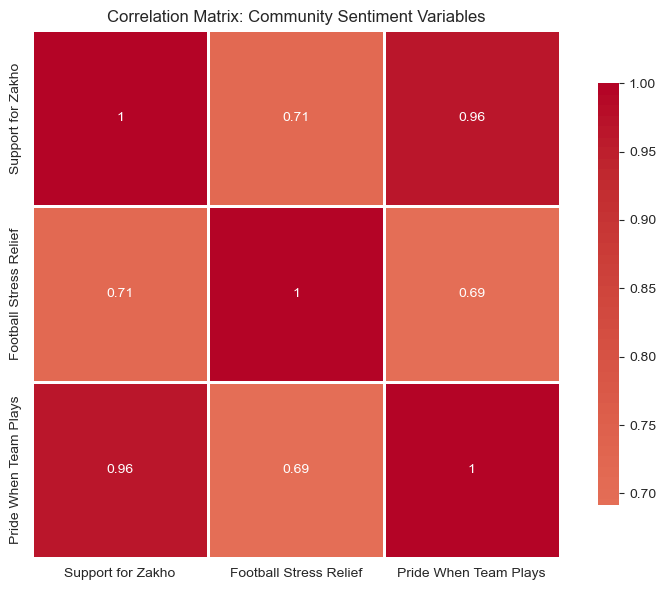

In [13]:
# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Community Sentiment Variables')
plt.tight_layout()
plt.show()

## Predicting Voting Behavior

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("="*70)
print("PREDICTING VOTING BEHAVIOR FROM SENTIMENT SCORES")
print("="*70)

# Prepare data
model_data = df[['voted_for_zakho'] + [v + '_num' for v in sentiment_vars]].dropna()

# Encode voting as binary (1=yes, 0=no)
y = (model_data['voted_for_zakho'] == 'yes').astype(int)
X = model_data[[v + '_num' for v in sentiment_vars]]

print(f"\nSample size: n={len(y)}")
print(f"Voted yes: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")
print(f"Voted no: {len(y)-y.sum()} ({(len(y)-y.sum())/len(y)*100:.1f}%)")

# Fit logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X, y)

# Predictions
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

print("\nModel Coefficients:")
for var, coef in zip(sentiment_labels, model.coef_[0]):
    print(f"  {var}: {coef:.3f}")
print(f"  Intercept: {model.intercept_[0]:.3f}")

print("\nModel Performance:")
print(f"Accuracy: {(y_pred == y).sum()/len(y)*100:.1f}%")
print(f"AUC-ROC: {roc_auc_score(y, y_prob):.3f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y, y_pred)
print(pd.DataFrame(cm, 
                   columns=['Predicted No', 'Predicted Yes'],
                   index=['Actual No', 'Actual Yes']))

print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

PREDICTING VOTING BEHAVIOR FROM SENTIMENT SCORES

Sample size: n=168
Voted yes: 157 (93.5%)
Voted no: 11 (6.5%)

Model Coefficients:
  Support for Zakho: 1.697
  Football Stress Relief: 1.303
  Pride When Team Plays: 1.547
  Intercept: -14.426

Model Performance:
Accuracy: 100.0%
AUC-ROC: 1.000

Confusion Matrix:
            Predicted No  Predicted Yes
Actual No             11              0
Actual Yes             0            157

Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        11
         Yes       1.00      1.00      1.00       157

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



In [15]:
# Individual predictor analysis
print("="*70)
print("INDIVIDUAL PREDICTORS OF VOTING BEHAVIOR")
print("="*70)

for var, label in zip(sentiment_vars, sentiment_labels):
    voted_yes = pd.to_numeric(df[df['voted_for_zakho']=='yes'][var], errors='coerce').dropna()
    voted_no = pd.to_numeric(df[df['voted_for_zakho']=='no'][var], errors='coerce').dropna()
    
    t_stat, p_val = stats.mannwhitneyu(voted_yes, voted_no, alternative='two-sided')
    d = cohens_d(voted_yes, voted_no)
    ci_lower, ci_upper = cohens_d_ci(voted_yes, voted_no)
    
    print(f"\n{label}")
    print("-" * 70)
    print(f"Voted Yes: M={voted_yes.mean():.2f}, SD={voted_yes.std(ddof=1):.2f}, n={len(voted_yes)}")
    print(f"Voted No:  M={voted_no.mean():.2f}, SD={voted_no.std(ddof=1):.2f}, n={len(voted_no)}")
    print(f"Mann-Whitney U: U={t_stat:.3f}, p={p_val:.4f}")
    print(f"Cohen's d={d:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")

INDIVIDUAL PREDICTORS OF VOTING BEHAVIOR

Support for Zakho
----------------------------------------------------------------------
Voted Yes: M=4.65, SD=0.48, n=157
Voted No:  M=2.14, SD=0.38, n=7
Mann-Whitney U: U=1099.000, p=0.0000
Cohen's d=5.275, 95% CI [4.319, 6.230]

Football Stress Relief
----------------------------------------------------------------------
Voted Yes: M=4.38, SD=0.57, n=157
Voted No:  M=2.00, SD=0.00, n=7
Mann-Whitney U: U=1099.000, p=0.0000
Cohen's d=4.241, 95% CI [3.349, 5.134]

Pride When Team Plays
----------------------------------------------------------------------
Voted Yes: M=4.65, SD=0.48, n=157
Voted No:  M=3.00, SD=0.00, n=7
Mann-Whitney U: U=1099.000, p=0.0000
Cohen's d=3.513, 95% CI [2.659, 4.366]
